In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO # type: ignore
import cv2
import json
import random
import os

## Using the via_region_data to parse the dataset

In [ ]:
training_folder = 'sign_dataset/train'
validation_folder = 'sign_dataset/val'

images_metadata = dict()

with open(f'{training_folder}/via_region_data.json') as annot:
    images_metadata = json.load(annot)

all_classes = {}
all_shapes = {}

image_metadata_keys = images_metadata.keys()

image_metadata = images_metadata['1531.jpg54171']
print(f"Image Metadata: {image_metadata}")

Image Metadata: {'fileref': '', 'size': 54171, 'filename': '1531.jpg', 'base64_img_data': '', 'file_attributes': {'width': 1280, 'height': 720}, 'regions': {'0': {'shape_attributes': {'name': 'ellipse', 'cx': 1083.5, 'cy': 313.5, 'rx': 26.5, 'ry': 26.5}, 'region_attributes': {'name': 'road sign'}}, '1': {'shape_attributes': {'name': 'polygon', 'all_points_x': [1091, 1120, 1107, 1082, 1091], 'all_points_y': [346, 530, 532, 344, 346]}, 'region_attributes': {}}}}


(-0.5, 1279.5, 719.5, -0.5)

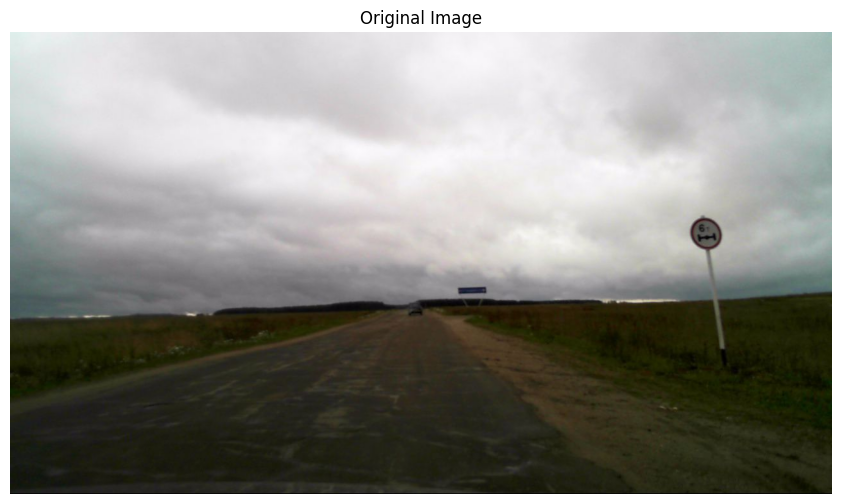

In [ ]:
filename = image_metadata['filename']

image_path = f"sign_dataset/train/{filename}"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
plt.figure(figsize=(12, 6))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')  


In [ ]:
print(f"Image metadata: {image_metadata}")

Image metadata: {'fileref': '', 'size': 54171, 'filename': '1531.jpg', 'base64_img_data': '', 'file_attributes': {'width': 1280, 'height': 720}, 'regions': {'0': {'shape_attributes': {'name': 'ellipse', 'cx': 1083.5, 'cy': 313.5, 'rx': 26.5, 'ry': 26.5}, 'region_attributes': {'name': 'road sign'}}, '1': {'shape_attributes': {'name': 'polygon', 'all_points_x': [1091, 1120, 1107, 1082, 1091], 'all_points_y': [346, 530, 532, 344, 346]}, 'region_attributes': {}}}}


# Analyzing the class balance of the dataset

Here, we want to see what are all the possible shapes there are in the dataset (shape_attributes) and maybe have a dictionary of the possible shapes. 

In [ ]:

def find_classes(images_metadata, data_type):
    """
    Function to parse the images_metadata and output the different classes

    args:
        images_metadata: Dictionary of the parsed via_region_
        images: List of images from train_dst.images, that gives the list of images
    return:
        classes [Dict]: Dictionary of the classes and the occurrences of
                        each class
        images [Dict]: Dictionary of each class and an image path that contains
                       that particular class
    """

# Forming the segmentation mask

Forming the segmentation mask of the dataset. 

=== REGION 0 === 
Shape attributes: {'name': 'ellipse', 'cx': 1083.5, 'cy': 313.5, 'rx': 26.5, 'ry': 26.5}
Region attributres: {'name': 'road sign'}


=== REGION 1 === 
Shape attributes: {'name': 'polygon', 'all_points_x': [1091, 1120, 1107, 1082, 1091], 'all_points_y': [346, 530, 532, 344, 346]}
Region attributres: {}




(-0.5, 1279.5, 719.5, -0.5)

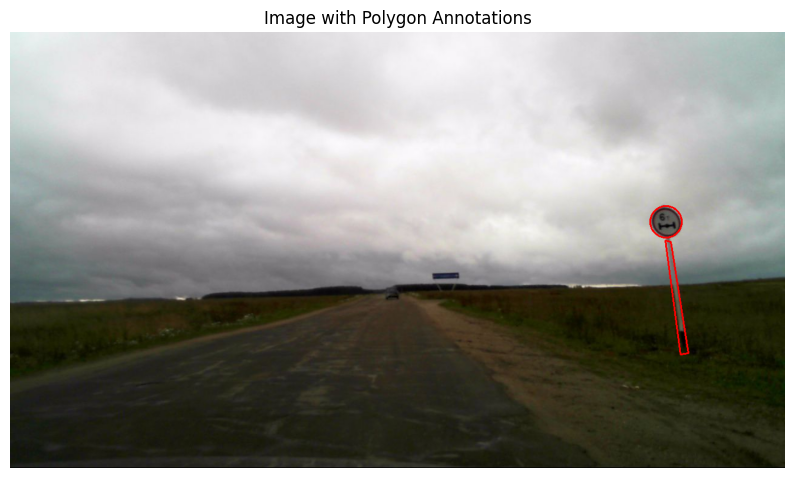

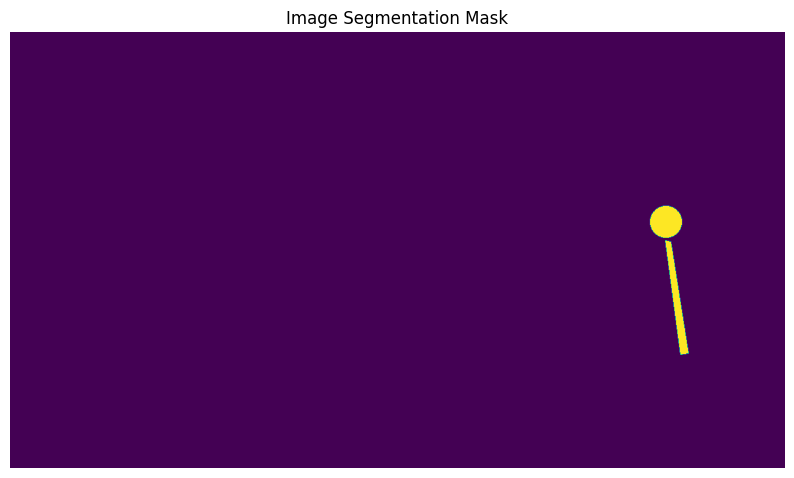

In [ ]:
image_regions = image_metadata['regions']
image_copy = image_rgb.copy()
image_height, image_width = image_copy.shape[0], image_copy.shape[1]

segmentation_mask = np.zeros((image_height, image_width), dtype=np.uint8)

for region_num in image_regions:
    region = image_regions[region_num]
    shape_attributes = region['shape_attributes']
    region_attributes = region['region_attributes']
    print(f"=== REGION {region_num} === ")
    print(f"Shape attributes: {shape_attributes}")
    print(f"Region attributres: {region_attributes}")
    print("\n")

    shape = shape_attributes['name']

    if shape == 'polygon':
        all_points_x = shape_attributes['all_points_x']
        all_points_y = shape_attributes['all_points_y']

        assert(len(all_points_x) == len(all_points_y))

        points = np.array([(x, y) for x, y in zip(all_points_x, all_points_y)], dtype=np.int32)
        points = points.reshape((-1, 1, 2))  
        
        cv2.polylines(image_copy, [points], isClosed=True, color=(255, 0, 0), thickness=2)
        cv2.fillPoly(segmentation_mask, [points], color=255)

    elif shape == 'ellipse':
        cx = shape_attributes['cx']
        cy = shape_attributes['cy']
        rx = shape_attributes['rx']
        ry = shape_attributes['ry']

        # Draw the ellipse on the image
        center = (int(cx), int(cy))
        axes = (int(rx), int(ry))
        cv2.ellipse(image_copy, center, axes, angle=0, startAngle=0, 
                    endAngle=360, color=(255, 0, 0), thickness=2)
        cv2.ellipse(segmentation_mask, center, axes, angle=0, startAngle=0, 
        endAngle=360, color=255, thickness=-1)

# Display the image with the polygons
plt.figure(figsize=(10, 10))
plt.imshow(image_copy)
plt.title("Image with Polygon Annotations")
plt.axis("off")

# Display the image with the polygons
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_mask)
plt.title("Image Segmentation Mask")
plt.axis("off")


## Segmentation for the entire dataset

We want to convert the dataset into images and their segmentation masks and save the segmentation masks


In [213]:
# Looping through the images meta_data

def segment_dataset(mode="train"):
    """
    args:
        mode: "train" or "val", depending on which dataset i want to segment
    """
    for image_key, image_metadata in images_metadata.items():
        image_name = images_metadata[image_key]['filename']
        image_path = f"sign_dataset/{mode}/{image_name}"
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image {image_name}. Skipping.")
            continue
        image_height, image_width = image.shape[0], image.shape[1]

        segmentation_mask = np.zeros((image_height, image_width), dtype=np.uint8)

        # Process each region in the metadata
        image_regions = image_metadata['regions']
        for region_num, region in image_regions.items():
            shape_attributes = region['shape_attributes']
            shape = shape_attributes.get('name', '')

            if shape == 'polygon':
                all_points_x = shape_attributes['all_points_x']
                all_points_y = shape_attributes['all_points_y']
                assert len(all_points_x) == len(all_points_y), "X and Y points must have the same length"

                # Create a list of (x, y) points for the polygon
                points = np.array([(x, y) for x, y in zip(all_points_x, all_points_y)], dtype=np.int32)
                points = points.reshape((-1, 1, 2))  # Reshape for cv2.fillPoly

                # Fill the polygon on the mask
                cv2.fillPoly(segmentation_mask, [points], color=255)

            elif shape == 'ellipse':
                cx = shape_attributes['cx']
                cy = shape_attributes['cy']
                rx = shape_attributes['rx']
                ry = shape_attributes['ry']
                center = (int(cx), int(cy))
                axes = (int(rx), int(ry))

                # Fill the ellipse on the mask
                cv2.ellipse(segmentation_mask, center, axes, angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)

        # Save the mask

        mask_path = f"sign_dataset/{mode}/{image_name.split('.')[0]}_mask.jpg"
        cv2.imwrite(mask_path, segmentation_mask)
        print(f"Saved mask for {image_name} at {mask_path}")

# Running the functions
segment_dataset(mode="train")
segment_dataset(mode="val")


Saved mask for 2050.jpg at sign_dataset/train/2050_mask.jpg
Saved mask for 2067.jpg at sign_dataset/train/2067_mask.jpg
Saved mask for 2056.jpg at sign_dataset/train/2056_mask.jpg
Saved mask for 2051.jpg at sign_dataset/train/2051_mask.jpg
Saved mask for 2052.jpg at sign_dataset/train/2052_mask.jpg
Saved mask for 1530.jpg at sign_dataset/train/1530_mask.jpg
Saved mask for 2021.jpg at sign_dataset/train/2021_mask.jpg
Saved mask for 1531.jpg at sign_dataset/train/1531_mask.jpg
Saved mask for 2022.jpg at sign_dataset/train/2022_mask.jpg
Saved mask for 1529.jpg at sign_dataset/train/1529_mask.jpg
Saved mask for 2023.jpg at sign_dataset/train/2023_mask.jpg
Saved mask for 2026.jpg at sign_dataset/train/2026_mask.jpg
Saved mask for 2025.jpg at sign_dataset/train/2025_mask.jpg
Saved mask for 2024.jpg at sign_dataset/train/2024_mask.jpg
Saved mask for 1030.jpg at sign_dataset/train/1030_mask.jpg
Saved mask for 1510.jpg at sign_dataset/train/1510_mask.jpg
Saved mask for 156.jpg at sign_dataset/t

[ WARN:0@77660.357] global loadsave.cpp:241 findDecoder imread_('sign_dataset/val/2050.jpg'): can't open/read file: check file path/integrity
[ WARN:0@77660.357] global loadsave.cpp:241 findDecoder imread_('sign_dataset/val/2067.jpg'): can't open/read file: check file path/integrity
[ WARN:0@77660.357] global loadsave.cpp:241 findDecoder imread_('sign_dataset/val/2056.jpg'): can't open/read file: check file path/integrity
[ WARN:0@77660.357] global loadsave.cpp:241 findDecoder imread_('sign_dataset/val/2051.jpg'): can't open/read file: check file path/integrity
[ WARN:0@77660.357] global loadsave.cpp:241 findDecoder imread_('sign_dataset/val/2052.jpg'): can't open/read file: check file path/integrity
[ WARN:0@77660.357] global loadsave.cpp:241 findDecoder imread_('sign_dataset/val/1530.jpg'): can't open/read file: check file path/integrity
[ WARN:0@77660.357] global loadsave.cpp:241 findDecoder imread_('sign_dataset/val/2021.jpg'): can't open/read file: check file path/integrity
[ WARN